In [1]:
import pretty_midi
import numpy as np
import os
import librosa.display
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')
    
    
    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

In [2]:
import plaidml.keras
plaidml.keras.install_backend()

In [5]:
keras.backend.backend()

'plaidml'

In [6]:
list_list = []
path = "./only_mel/"
for file_name in os.listdir("./only_mel/"):
    mel = pretty_midi.PrettyMIDI(path + file_name)
    path_org = "./merged/"
    org = pretty_midi.PrettyMIDI(path_org + file_name)
    org_roll = org.get_piano_roll(100)
    mel_roll = mel.get_piano_roll(100)
    size = org_roll.shape
    mel_roll_re = np.array(Image.fromarray(mel_roll).resize((size[1],size[0]), Image.BILINEAR)).astype(np.double)
    list_list.append([mel_roll_re,org_roll])
    
    
    

In [7]:
def list_truncator(list_list):
    
    len_list = []
    for i in range(len(list_list)):
        len_list.append(list_list[i][0].shape[1])
    
    min_len = 16384

    for i in range(len(list_list)):
        list_list[i][0] = list_list[i][0][:,:min_len]
        list_list[i][1] = list_list[i][1][:,:min_len]
        
    return list_list


In [8]:
list_list = list_truncator(list_list)

In [9]:
#두 인풋과 아웃풋 이미지 파일을 옆으로 합칩니다 씨발
new_list = []
for idx in range(len(list_list)):
    new_list.append(np.hstack([list_list[idx][0], list_list[idx][1]]))

In [10]:
import tensorflow as tf
import keras

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [11]:
BUFFER_SIZE = 19
BATCH_SIZE = 1
IMG_WIDTH = list_list[0][0].shape[1]
IMG_HEIGHT = 128

In [12]:
def load(image):

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w]
  input_image = image[:, w:]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [10]:
inp ,re = load(new_list[3])
inp

<tf.Tensor: shape=(128, 16384), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [13]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [14]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [15]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices(new_list)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [17]:
test_dataset = tf.data.Dataset.from_tensor_slices(new_list)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [18]:
OUTPUT_CHANNELS = 1

In [19]:
train_dataset.enumerate()

<ZipDataset shapes: ((), ((None, 128, 16384), (None, 128, 16384))), types: (tf.int64, (tf.float32, tf.float32))>

In [20]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [21]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(tf.expand_dims(inp, 0),-1))
down_result.shape

NameError: name 'inp' is not defined

In [22]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [23]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[128,16384,1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 64, 10217, 64)
    downsample(128, 4), # (bs, 32, 5109, 128)
    downsample(256, 4), # (bs, 16, 2555, 256)
    downsample(512, 4), # (bs, 8, 1278, 512)
    downsample(512, 4), # (bs, 4, 639, 512)
    downsample(512, 4), # (bs, 2, 320, 512)
    downsample(512, 4), # (bs, 1, 160, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 320, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 640, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 1280, 1024)
    upsample(256, 4), # (bs, 16, 2560, 1024)
    upsample(128, 4), # (bs, 32, 5120, 512)
    upsample(64, 4), # (bs, 64, 10240, 256)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 128, 20480, 3)
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    
    x = tf.keras.layers.Concatenate(axis = -1)([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [24]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [25]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

NameError: name 'inp' is not defined

In [26]:
LAMBDA = 100

In [27]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [28]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[128, 16384, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[128, 16384, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 128, 20434, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 64, 10217, 64)
  down2 = downsample(128, 4)(down1) # (bs, 32, 5109, 128)
  down3 = downsample(256, 4)(down2) # (bs, 16, 2555, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 18, 2557, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 15, 2554, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 17, 2556, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 14, 2553, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [29]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [30]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [31]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [32]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [33]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [34]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  display_list = [test_input[0], tar[0], tf.squeeze(prediction[0])]

  librosa.display.specshow(display_list[2].numpy()*0.5 + 0.5)
    

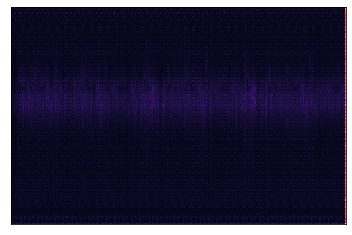

In [41]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [35]:
for example_input, example_target in test_dataset.take(1):
    print(example_input*0.5+0.5)
    print(example_input*0.5+0.5)

tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]], shape=(1, 128, 16384), dtype=float32)
tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]], shape=(1, 128, 16384), dtype=float32)


In [36]:
EPOCHS = 150

In [37]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [38]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [39]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      input_image = tf.expand_dims(input_image, -1)
      target = tf.expand_dims(target, -1)
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
        
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

Epoch:  3
.

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7ffeaf593b80>
Traceback (most recent call last):
  File "/Users/gimseonghun/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 536, in __del__
    gen_dataset_ops.delete_iterator(
  File "/Users/gimseonghun/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1277, in delete_iterator
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
KeyboardInterrupt: 
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/gimseonghun/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-91e4b5f743cc>", line 1, in <module>
    fit(train_dataset, EPOCHS, test_dataset)
  File "<ipython-input-39-b1ce303d3a09>", line 19, in fit
    train_step(input_image, target, epoch)
  File "/Users/gimseonghun/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 780, in __call__
    result = self._call(*args, **kwds)
  File "/Users/gimseonghun/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 807, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "/Users/gimseonghun/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 2829, in __call__
    return graph_function._filtered_call(args, kwargs)  # pylint: d

TypeError: object of type 'NoneType' has no len()

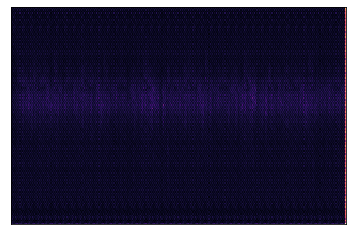

In [40]:
fit(train_dataset, EPOCHS, test_dataset)

In [118]:
train_dataset

<BatchDataset shapes: ((None, 128, 20434), (None, 128, 20434)), types: (tf.float32, tf.float32)>

In [119]:
test_dataset

<BatchDataset shapes: ((None, 128, 20434), (None, 128, 20434)), types: (tf.float32, tf.float32)>